<a href="https://colab.research.google.com/github/pepetonof/IC-Tutorial/blob/main/Tutorial-IC-8Queens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install deap

In [12]:
from deap import algorithms
from deap import base
from deap import creator
from deap import tools
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

#Problema delas 8 reinas

El problema de las ocho damas no es estrictamente ajedrecístico, porque no se puede producir en una partida real debido a la ausencia de los reyes, no por la proliferación de reinas. Fue planteado por primera vez por el ajedrecista Max Bezzel en 1848, en la revista ‘Berliner Schachzeitung’.

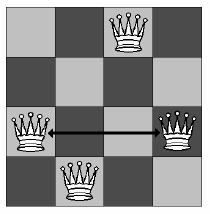

# Representaciones
Recordar que las reinas no deben compartir fila, columna o diagonal!

## Representación de matriz binaria
1. Proporciona una representación visual del tablero de ajedrez
2. Alamcenamiento de ceros
3. Requiere **verificar conflictos en filas, columnas y diagonales**



  [0, 0, 1, 0], <br>
  [0, 0, 0, 0], <br>
  [1, 0, 0, 1], <br>
  [0, 1, 0, 0], <br>


## Representación de permutaciones
1. Elimina la necesitad de almacenar ceros para las posiciones vacías
2. Facilita la verificación de restricciones comparando los indices de las columnas. Solo se necesita **verificar conflictos en las diagonales**

 [2, **empty**, 0/3, 1] <br>

In [13]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", np.ndarray, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("permutation", random.sample, range(8), 8)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.permutation)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

#fitness function taken from:
#https://github.com/LuisAlejandroSalcedo/Problema-de-las-N-Reinas/blob/master/NQueens.py
def fitness(individual):
    size = len(individual)

    #solo ataques en diagonal
    diagonal_izquierda_derecha = [0] * (2*size-1)
    diagonal_derecha_izquierda = [0] * (2*size-1)

    #no. de 1s en casa diago
    for i in range(size): # recorremos las columnas
        diagonal_izquierda_derecha[i+individual[i]] += 1 # [columna + fila]
        diagonal_derecha_izquierda[size-1-i+individual[i]] += 1 # [size-1-columna+ fila]

    suma = 0
    for i in range(2*size-1): # recorremos todas las diagonales
        if diagonal_izquierda_derecha[i] > 1: # hay ataques
            suma += diagonal_izquierda_derecha[i] - 1 # n-1 ataques
        if diagonal_derecha_izquierda[i] > 1:
            suma += diagonal_derecha_izquierda[i] - 1
    return suma,

toolbox.register("evaluate", fitness)
toolbox.register("mate", tools.cxPartialyMatched)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=2.0/8)
toolbox.register("select", tools.selTournament, tournsize=3)

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [53]:
stats_fit = tools.Statistics(lambda ind: ind.fitness.values[0])
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

def similar(ind1, ind2):
    """
    A custom similarity function that compares two individuals
    element-wise and returns True if they are identical, False otherwise.
    """
    return np.array_equal(ind1, ind2) # Use NumPy's array_equal for element-wise comparison

def varAnd(population, toolbox, cxpb, mutpb):
    offspring = [toolbox.clone(ind) for ind in population]
    # Apply crossover and mutation on the offspring
    for i in range(1, len(offspring), 2):
        if random.random() < cxpb:
            offspring[i - 1], offspring[i] = toolbox.mate(offspring[i - 1],
                                                          offspring[i])
            del offspring[i - 1].fitness.values, offspring[i].fitness.values

    for i in range(len(offspring)):
        if random.random() < mutpb:
            offspring[i], = toolbox.mutate(offspring[i])
            del offspring[i].fitness.values

    return offspring

def plot_individual(individual):
    x= range(8)
    x= np.array(x)
    y= individual
    y = np.array(y)
    x = x + 0.5
    y = y + 0.5
    fig, ax = plt.subplots()
    scatter = ax.scatter(x,y)
    ax.set_xlim(0,8)
    ax.set_ylim(0,8)
    ax.set_xticks(x-0.5)
    ax.set_yticks(x-0.5)
    ax.grid(True)
    ax.set_title(f"Mejor Individuo \t"+str(individual))
    return fig, scatter


def ea(population, toolbox, cxpb, mutpb, ngen, stats=None,
             halloffame=None, verbose=__debug__):

  logbook = tools.Logbook()
  logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

  invalid_ind = [ind for ind in population if not ind.fitness.valid]
  fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
  for ind, fit in zip(invalid_ind, fitnesses):
      ind.fitness.values = fit

  if halloffame is not None:
      halloffame.update(population)

  record = stats.compile(population) if stats else {}
  logbook.record(gen=0, nevals=len(invalid_ind), **record)
  if verbose:
      print(logbook.stream)

  fig, ax = plt.subplots()
  x = np.array(range(8))
  x = x + 0.5
  ax.grid(True)
  ax.set_xticks(x-0.5)
  ax.set_yticks(x-0.5)
  ax.set_xlim(0,8)
  ax.set_ylim(0,8)

  frames = []

  # Begin the generational process
  for gen in range(1, ngen + 1):
      best = tools.selBest(population, 1)[0]

      scatter = ax.scatter(x,np.array(best)+0.5)
      ax.set_title(u'Mejor Individuo '+ str(gen))
      frames.append([scatter])

      if best.fitness.values == (0,):
          print("Best individual is: %s, %s" % (best, best.fitness.values))
          break
      # Select the next generation individuals
      offspring = toolbox.select(population, len(population))

      # Vary the pool of individuals
      offspring = varAnd(offspring, toolbox, cxpb, mutpb)

      # Evaluate the individuals with an invalid fitness
      invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
      fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
      for ind, fit in zip(invalid_ind, fitnesses):
          ind.fitness.values = fit

      # Update the hall of fame with the generated individuals
      if halloffame is not None:
          halloffame.update(offspring)

      # Replace the current population by the offspring
      population[:] = offspring

      # Append the current generation statistics to the logbook
      record = stats.compile(population) if stats else {}
      logbook.record(gen=gen, nevals=len(invalid_ind), **record)
      if verbose:
          print(logbook.stream)

  ani = animation.ArtistAnimation(fig, frames, interval=2000, blit=True, repeat=False)
  writer = animation.PillowWriter(fps=10)
  ani.save('./eight_queens.gif', writer=writer)

  return population, logbook

gen	nevals	avg	std     	min	max
0  	10    	3.5	0.921954	2  	5  
1  	6     	3.4	1.56205 	1  	6  
2  	6     	3  	1.09545 	2  	5  
3  	4     	3.2	1.249   	2  	6  
4  	8     	3.5	1.56525 	2  	6  
5  	8     	3.3	1.55242 	2  	6  
6  	6     	2.7	1.00499 	2  	5  
7  	5     	2.6	1.0198  	2  	5  
8  	7     	3.5	1.56525 	2  	6  
9  	8     	3  	1.41421 	2  	7  
10 	9     	3.7	1.95192 	2  	9  
11 	7     	3.3	1.1     	1  	5  
12 	7     	3.3	0.9     	1  	4  
13 	9     	3  	1       	1  	5  
14 	7     	2.5	1.28452 	1  	5  
15 	8     	2.6	1.11355 	1  	4  
16 	6     	2.6	1.74356 	1  	6  
17 	9     	2.5	1.28452 	1  	5  
18 	10    	3.4	0.663325	3  	5  
19 	8     	3.3	0.781025	2  	5  
20 	7     	3  	0.774597	2  	4  
21 	5     	3.3	1.26886 	2  	6  
22 	7     	3  	0.774597	2  	4  
23 	7     	2.7	1.00499 	2  	5  
24 	8     	2.7	1.41774 	2  	6  
25 	6     	2.5	1.36015 	1  	6  
26 	9     	2.7	0.9     	1  	4  
27 	9     	2.5	0.806226	1  	4  
28 	8     	3.3	1.26886 	1  	5  
29 	9     	3.1	1.22066 	1  	5  
30 	9   

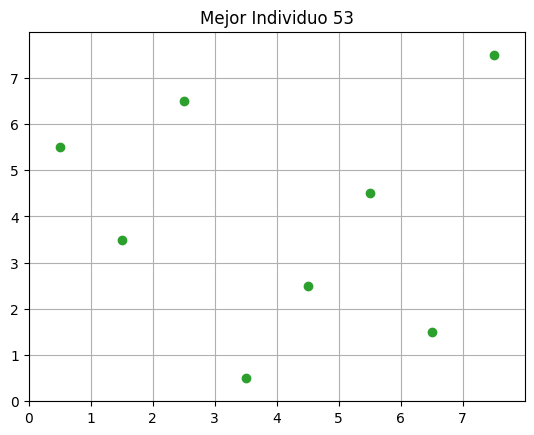

In [54]:
pop = toolbox.population(n=10)
hof = tools.HallOfFame(10)
# Overwrite the default `similar` method in the HallOfFame class
hof.similar = similar
pop, log = ea(pop, toolbox, 0.5, 0.5, 90, stats=stats,
              halloffame=hof, verbose=True)

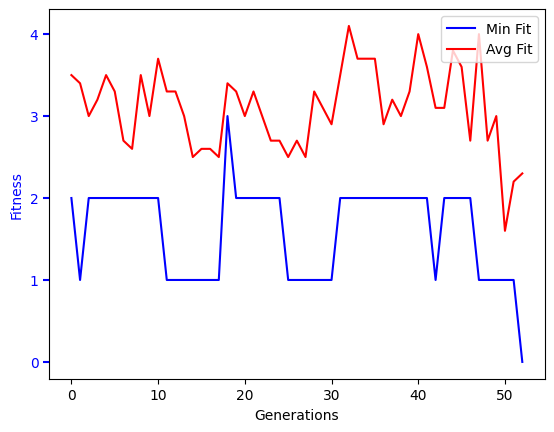

In [55]:
def convergence_graph(logbook, name):
  gen=logbook.select("gen")
  fit_max=logbook.select("min")
  fit_avg=logbook.select("avg")
  fig, host = plt.subplots()
  p1, = host.plot(gen, fit_max, "b-", label="Min Fit")
  p2, = host.plot(gen, fit_avg, "r-", label="Avg Fit")
  host.set_xlabel("Generations")
  host.set_ylabel("Fitness")
  host.yaxis.label.set_color(p1.get_color())
  tkw = dict(size=4, width=1.5)
  host.tick_params(axis='y', colors=p1.get_color(), **tkw)
  lines = [p1,p2]

  host.legend(lines, [l.get_label() for l in lines], loc="upper right")
  # fig.savefig(ruta+"/Convergencia.png")
  fig.savefig("./"+name)
  # plt.close(fig)
  plt.show()

convergence_graph(log, "GraficaConvergencia")